In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
import datetime
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Weather Stations against Historic Mean

It's useful to compare the FWI or other station data against historic conditions. Below are some functions and helper-objects for accessing the station network.

In [9]:
## Helper objects. These correspond to the paths where Non-US stations are stored. For CONUS-station helper objects, see below. 
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT.nStns.18/") 
files

In [13]:
cheat_sheet = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT.nStns.18/20230718.isd-history.csv")
cheat_sheet['STATION NAME'].unique()

array(['WXPOD 7018', 'WXPOD 7026', 'WXPOD 7070', ...,
       'IONIA COUNTY AIRPORT', 'DEMOPOLIS MUNICIPAL AIRPORT',
       'BRANSON WEST MUNICIPAL EMERSON FIELD AIRPORT'], dtype=object)

In [2]:
st_id_map = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT.nStns.18/20230718.isd-history.csv") ## For mappting ID's to lat lounique Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, 
                      path_s3 = 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT.nStns.18/FWI/', 
                      inter_type = '.linear.HourlyFWIFromHourlyInterpContinuous.csv')
st_dict = stations[['Lat', 'Lon']].to_dict('records')

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT.nStns.18/FWI/


The function that plots station data against a historical mean is called `plot_st_history`. `plot_st_history` is fairly flexible. It allows you to choose a station according to either a known path, a USAF_WBAN id, or a lat lon. You can access my pre-built functions by typing `fv.{functionname}` like so:

In [3]:
?fv.plot_st_history

Signature:
fv.plot_st_history(
    st_id_map,
    st_dict,
    stations,
    title=None,
    path=None,
    lat_lon=None,
    USAF_WBAN=None,
    seasons=[5, 6, 7],
    year=None,
    plot_var='FWI',
    clim_normal_min=datetime.datetime(1991, 1, 1, 0, 0),
    clim_normal_max=datetime.datetime(2020, 12, 31, 0, 0),
)
Docstring:
Plots weather station data against historic means. Stations can be plotted form a file path, an USAF_WBAN id, or a lat and lon combination. If no station is at the exact lat lon, the function will search for the closest one. 

INPUTS:
    st_dict (dict): A  dictionary with "Lat" and "Lon" entries for each weather station. A dictionary of the output from st_avail.
    stations (DataFrame): a dataframe as outputted by st_avail. A dataframe with columns for station lat, lon, and ID.
    st_id_map (DataFrame): a dataframe that connects Station IDs to full names and locations. 
    title (str):  An optional title for the plot. Optional. "None" is default. If "None", t

By default, this function will plot FWI. 

Plotting most-recent year and seasons:[5, 6, 7]


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:372: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:381: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:386: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify 

,YYYY,MM,DD,HH,TEMP_C,RH_PERC,VPD_HPA,WDSPD_KPH,PREC_MM,SNOWD_M,...,FWI,OBSMINUTEDIFF_TEMP,OBSMINUTEDIFF_RH,OBSMINUTEDIFF_WDSPD,ISPRECREPORTED,OBSMINUTEDIFF_SNOW,OBSMINUTEDIFF_VIS,HH_format,time,isinseason
0,1990,1,1,8,NaN,NaN,NaN,NaN,0.125,NaN,...,NaN,1440.0,1440.0,1440.0,1,1440.0,1440.0,08,1990-01-01 08:00:00,False
1,1990,1,1,9,NaN,NaN,NaN,NaN,0.125,NaN,...,NaN,1380.0,1380.0,1380.0,1,1380.0,1380.0,09,1990-01-01 09:00:00,False
2,1990,1,1,10,NaN,NaN,NaN,NaN,0.125,NaN,...,NaN,1320.0,1320.0,1320.0,1,1320.0,1320.0,10,1990-01-01 10:00:00,False
3,1990,1,1,11,NaN,NaN,NaN,NaN,0.125,NaN,...,NaN,1260.0,1260.0,1260.0,1,1260.0,1260.0,11,1990-01-01 11:00:00,False
4,1990,1,1,12,NaN,NaN,NaN,NaN,0.125,NaN,...,NaN,1200.0,1200.0,1200.0,1,1200.0,1200.0,12,1990-01-01 12:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294017,2023,7,18,1,25.567,79.399,6.8474,9.36,0.000,0.0,...,2.4107,120.0,120.0,120.0,0,120.0,120.0,01,2023-07-18 01:00:00,True
294018,2023,7,18,2,24.900,82.933,5.3709,9.36,0.000,0.0,...,2.3237,0.0,0.0,0.0,0,0.0,0.0,02,2023-07-18 02:00:00,True
294019,2023,7,18,3,24.433,84.990,4.6318,8.04,0.000,0.0,...,1.9839,120.0,120.0,120.0,0,120.0,120.0,03,2023-07-18 03:00:00,True
294020,2023,7,18,4,23.967,87.046,3.8928,6.72,0.000,0.0,...,1.6239,120.0,120.0,120.0,0,120.0,120.0,04,2023-07-18 04:00:00,True


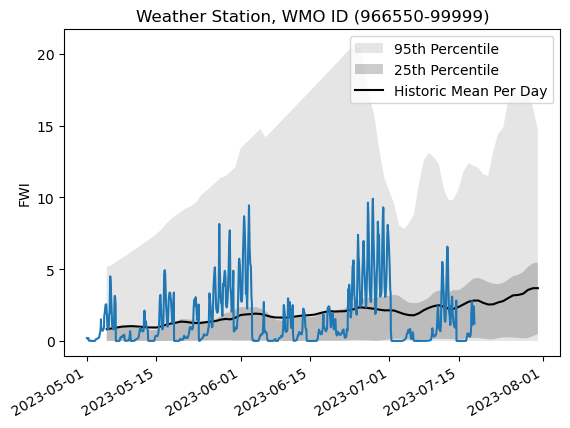

In [4]:
fv.plot_st_history(st_id_map = st_id_map, st_dict = st_dict, stations = stations, USAF_WBAN = ['966550', '99999'],seasons=[5,6,7],plot_var='FWI')

But it can also plot any of the data assosiated with the stations. It can also search for the closes station to a given lat lon. 

The closest station is 482.5032055472788 km away.
Plotting most-recent year and seasons:[5, 6, 7]


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:372: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:381: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:386: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify 

,YYYY,MM,DD,HH,TEMP_C,RH_PERC,VPD_HPA,WDSPD_KPH,PREC_MM,SNOWD_M,...,FWI,OBSMINUTEDIFF_TEMP,OBSMINUTEDIFF_RH,OBSMINUTEDIFF_WDSPD,ISPRECREPORTED,OBSMINUTEDIFF_SNOW,OBSMINUTEDIFF_VIS,HH_format,time,isinseason
0,1989,12,31,19,-15.0,88.305,0.22420,3.6000,0.008333,0.42,...,NaN,0,0,0,1,0,0,19,1989-12-31 19:00:00,False
1,1989,12,31,20,-16.0,77.675,0.39374,3.6000,0.008333,0.00,...,NaN,0,0,0,1,0,0,20,1989-12-31 20:00:00,False
2,1989,12,31,21,-17.0,84.436,0.25246,3.6000,0.008333,0.00,...,NaN,0,0,0,1,0,0,21,1989-12-31 21:00:00,False
3,1989,12,31,22,-18.0,84.308,0.23448,8.1953,0.008333,0.00,...,NaN,60,60,44,1,44,44,22,1989-12-31 22:00:00,False
4,1989,12,31,23,-19.0,84.180,0.21650,7.5600,0.008333,0.00,...,NaN,0,0,0,1,0,0,23,1989-12-31 23:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293946,2023,7,14,13,22.2,44.689,14.80900,16.5600,0.000000,0.00,...,26.320,0,0,0,0,0,0,13,2023-07-14 13:00:00,True
293947,2023,7,14,14,24.0,41.168,17.56000,25.9200,0.000000,0.00,...,38.464,0,0,0,0,0,0,14,2023-07-14 14:00:00,True
293948,2023,7,14,15,26.0,36.541,21.33500,24.1200,0.000000,0.00,...,39.159,0,0,0,0,0,0,15,2023-07-14 15:00:00,True
293949,2023,7,14,16,24.3,37.553,18.97700,16.5600,0.000000,0.00,...,31.904,0,0,0,0,0,0,16,2023-07-14 16:00:00,True


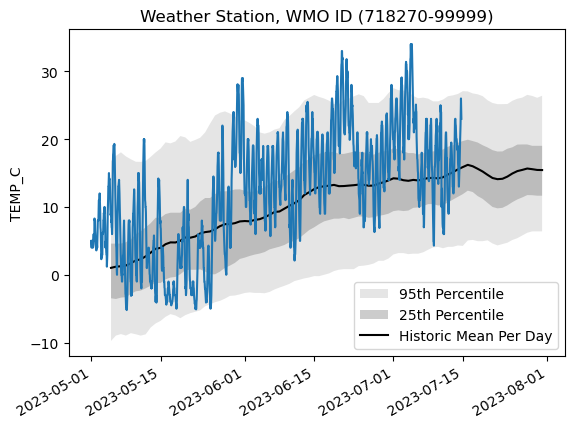

In [5]:
fv.plot_st_history(st_id_map = st_id_map, st_dict = st_dict, stations = stations, lat_lon = [50.52, -72.768], plot_var = 'TEMP_C')

# Station plotting functions

Here is the raw code I used to define the functions above, which may be useful if you would like to make fixed or tweaks to the functions. They should work the same way as the `fv.{fucntion_name}`, but without the `fv`. 

In [6]:
def distance(lat1, lon1, lat2, lon2):
    '''
    Finds distance in km between two points designated with lat and lon values 
    
    INPUTS:
        
        lat1 (str):  A  lattitude
        lon1 (str):  A longitude
        lat2 (str):  second lattitude
        lon2 (str):  second longitude 
    
    '''
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav)) ## Returns in km

def closest(data, v):
    '''
    Will return the shortests distance between one lat/lon point and a dictionary of several lat/lon points. 
    
    INPUTS:
        
        data (dict):  A  dictionary with "Lat" and "Lon" entries to compare to v
        v (dict):  A dictinary with a single "Lat" and "Lon" entry. 
    
    '''
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    #this_station = data[(data['Lat'] == mn['Lat']) & (data['Lon'] == mn['Lon'])]
    #print("The closest station is", this_station["STATION NAME"]," USAF: ", this_station["USAF"],"located at Lat", mn['Lat']," and Lon",mn['Lon'],  "and is ",  dist, "km away." )
    print("The closest station is",  dist, "km away." )
    return mn

def date_convert(dat_time):
    '''
    Takes a data frame with the columns "YYYY", "MM", "DD", and "HH" and converts those columns into a single datetime column. 
    
    INPUTS:
        
        dat_time (DataFrame):  A data frame with the columns "YYYY", "MM", "DD", and "HH". Hours do not have leading zeros. 
    
    '''
    dat_time.HH = dat_time.HH.astype('int') # Drop #.0
    dat_time.HH = dat_time.HH.astype('str')
    dat_time['HH_format'] = dat_time.HH.apply(hour_fix)
    dat_time['time'] = pd.to_datetime(dat_time['YYYY'].astype(str) +"-"+  dat_time['MM'].astype("str") +"-"+  dat_time['DD'].astype("str") + " " + dat_time['HH_format'].astype('str'), format='%Y-%m-%d %H')

    return(dat_time)

def hour_fix (hr):
    '''
    Appends a leading 0 to hours for date formatting 
    
    INPUTS:
        
        hr (str): An hour digit from 0-24
    
    '''
    small_hr = ["0","1","2","3","4","5","6","7","8","9"]
    append = ""
    
    if (hr in small_hr):
        append = "0"
    hr = append + hr
    
    return(hr)

def plot_st_history(st_id_map, st_dict, stations, title = None, path = None, lat_lon = None, USAF_WBAN = None, seasons = [5, 6, 7], year = None, plot_var = "FWI", clim_normal_min = datetime.datetime(1991, 1, 1), 
    clim_normal_max = datetime.datetime(2020, 12, 31), rolling_mean_days = 5):
    '''
    Plots weather station data against historic means. Stations can be plotted form a file path, an USAF_WBAN id, or a lat and lon combination. If no station is at the exact lat lon, the function will search for the closest one. 
    
    INPUTS:
        st_dict (dict): A  dictionary with "Lat" and "Lon" entries for each weather station. A dictionary of the output from st_avail.
        stations (DataFrame): a dataframe as outputted by st_avail. A dataframe with columns for station lat, lon, and ID.
        st_id_map (DataFrame): a dataframe that connects Station IDs to full names and locations. 
        title (str):  An optional title for the plot. Optional. "None" is default. If "None", title will be the WMO ID of the station. 
        path (str):  Path to staion data csv. Optional. Default to "None". 
        lat_lon (list): A list of the form [lat_float, lon_float]. Optional. If lat and lon are not exact matches, function will search for closest station. 
        USAF_WBAN (list): List of the form [USAF, WBAN]. Optional. 
        seasons (list): List with single-digit representations of months to include in averaging across years. Default [5, 6, 7] or May, June and July. 
        year (str): The year of station data to compare to historic means. Defaults to "None", where the most recent data will be compared.
        plot_var (str): Variable to plot. Defaults to "FWI". 
        clim_normal_min (datetime): minimum period for climate normal. Defaults to January 1, 1991. If station data doesn not extend as far back as minimum, normal will be on min of station data and will throw a warning. 
        clim_normal_max (datetime): Maximum period for climate normal. Defaults to December 31st, 2020. If station data doesn not extend into maximum, normal will be on max of station data and will throw a warning. 
        rolling_mean_days (int): Number of days overwhich to apply a rolling mean on quantiles. Provides a smoothing effect. Default to 5. 
    '''
    
    ## Find closest station, iether by ID, or Lon + Lat
    if(all([path == None, lat_lon == None, USAF_WBAN == None])):
        print("Error: No specifying information provided. Please include a path to station, a lat-lon, or a USAF_WBAN id. ")
    if(path == None):
        if( not USAF_WBAN == None ):
            st = stations.loc[(stations.USAF == USAF_WBAN[0]) & (stations.WBAN == USAF_WBAN[1])]
            path = "s3://" + st.File_path.iloc[0]
        else:
            st = stations.loc[(stations.Lat == lat_lon[0]) & (stations.Lon== lat_lon[1])]
            if(len(st) == 0):
                st_cls = closest(st_dict, pd.DataFrame(data = {"Lat" :[lat_lon[0]], "Lon" :  [lat_lon[1]]}))
                st = stations.loc[(stations.Lat == st_cls["Lat"]) & (stations.Lon == st_cls["Lon"])]
                
            path = "s3://" + st.File_path.iloc[0]
    
    ## Find the name of station if no title provided
    if(title == None):
        split = re.split(pattern = "/", string = path)
        split = split[-1]
        WMO_id = re.sub(pattern = "\..*", repl = "",  string = split)
        extra = ""
        if("s3://" in path):  
            id_split = re.split(pattern = "-", string = WMO_id)
            labs = st_id_map[(st_id_map.USAF == str(id_split[0])) & (st_id_map.WBAN == str(id_split[1]))]
            extra = str(*labs['STATION NAME'])  + str(*labs['CTRY'])+ ", " + str(*labs['STATE'])
        title = "Weather Station" + extra +  "WMO ID (" + WMO_id + ")"

    # Read in station data
    st = pd.read_csv(path)
    if(not np.any(st.columns.isin(["HH"]))):
         st['HH'] = '12'
    st.YYYY = st.YYYY.astype("int")
    st.MM = st.MM.astype("int")
    st.DD = st.DD.astype("int")
    st.HH = st.HH.astype("int")
    st = date_convert(st)
    
    # Add leading zeros to month parameters
    max_season = max(seasons)
    if(max_season <= 9):
        max_season = "0" + str(max_season)
    min_season = min(seasons)
    if(min_season <= 9):
        min_season = "0" + str(min_season)
    min_season = str(min_season)
    max_season = str(max_season)
    
    #Subset to time-period of interest, default to most recent
    if(year == None):
        print("Plotting most-recent year and seasons:" + str(seasons))
        #ctime = datetime.datetime.now()
        #year = str(ctime.year)
        year = str(max(st.time.dt.year))
    else:
        year = year
    
    max_day = year + "-" + max_season + "-30 23:00:00" ## Hack
    min_day = year + "-" + min_season + "-01 00:00:00"
        
    # Subset to months requested
    st['isinseason'] = st.MM.isin(seasons) # Is in the seasons provided? 
    mj = st[st['isinseason'] == True]
    mj = mj.set_index("time")
    
     # Try to use 1991-2020, or user supplied range as climate normal. If not possible, get as close as you can. 
    upper_range = str(min(clim_normal_max, max(st.time)))
    lower_range = str(max(clim_normal_min, min(st.time)))
   
    if((min(st.time) > clim_normal_min) |  (max(st.time) < clim_normal_max)):
        print("WARNING: Station record does not cover assumed climate normal (1991-2020).")

        print("Using range " + upper_range + ":" + lower_range + " instead.")
        mj = mj[mj.index > max(clim_normal_min, min(st.time))]
        mj = mj[mj.index < min(clim_normal_max, max(st.time))]
        
    mj = mj[mj.index.strftime('%m-%d') != '02-29'] # Drop leap-day becuase it's only sampled once every 4 years

    # Find quantiles
    mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()

    dates = ( year + "-" + mean_quant.index.get_level_values(level=1).astype("str") + "-" + mean_quant.index.get_level_values(level=0).astype("str"))

    mean_quant["dates"] = pd.to_datetime(dates)
    mean_quant = mean_quant.sort_values(by = "dates")
    mean_quant.set_index("dates", inplace = True)


    upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
    upper["dates"] = pd.to_datetime(dates)
    upper = upper.sort_values(by = "dates")
    upper.set_index("dates", inplace = True)

    lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.025)
    lower["dates"] = pd.to_datetime(dates)
    lower = lower.sort_values(by = "dates")
    lower.set_index("dates", inplace = True)


    mid_lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.25)
    mid_lower["dates"] = pd.to_datetime(dates)
    mid_lower = mid_lower.sort_values(by = "dates")
    mid_lower.set_index("dates", inplace = True)


    mid_upper = mj.groupby([mj.index.day, mj.index.month]).quantile(0.75)
    mid_upper["dates"] = pd.to_datetime(dates)
    mid_upper = mid_upper.sort_values(by = "dates")
    mid_upper.set_index("dates", inplace = True)
    
    st = st.sort_values(by = ["time"])
    try:
        upper[plot_var].rolling(5).mean()
    except:
        print("plot_var is not present in this weather station. Columns are: " + str(st.columns))
        return(None)
    
    daily_vars = ["DC", "BUI", "DMC", "PREC_MM"] # Vars that are daily even with hourly station data
    
    # Plot
    fig, ax = plt.subplots()
    ax.fill_between(upper.index, upper[plot_var].rolling(rolling_mean_days).mean(), lower[plot_var].rolling(rolling_mean_days).mean(), 
                    facecolor='grey', 
                    alpha=0.2,
                    label= "95th Percentile")
    ax.fill_between(mid_upper.index, mid_upper[plot_var].rolling(rolling_mean_days).mean(), mid_lower[plot_var].rolling(rolling_mean_days).mean(), 
                    facecolor='grey', 
                    alpha=0.4,
                    label= "25th Percentile")
    ax.plot(mean_quant.index, mean_quant[plot_var].rolling(rolling_mean_days).mean(), 
            color = "black",
            label= "Historic Mean Per Day")
    if(plot_var in daily_vars):
        tmp = st.dropna()
        ax.plot(tmp[(tmp.time >= min_day) & (tmp.time <= max_day)].time.astype('datetime64[ns]'), tmp[(tmp.time >= min_day) & (tmp.time <= max_day)][plot_var])
    else:
        ax.plot(st[(st.time >= min_day) & (st.time <= max_day)].time.astype('datetime64[ns]'), st[(st.time >= min_day) & (st.time <= max_day)][plot_var])    
    ax.set_ylabel(plot_var)
    ax.set_xlabel("\n" + "Climate normals based on" + str(lower_range) + " to " + str(upper_range) + ". " + "Rolling"+"-daily mean applied to percentile")
    ax.set_title(title)
    ax.legend()
    fig.autofmt_xdate()
    return(st)



The closest station is 482.5032055472788 km away.
Plotting most-recent year and seasons:[5, 6, 7]


/tmp/ipykernel_701/1510034908.py:167: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/tmp/ipykernel_701/1510034908.py:176: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/tmp/ipykernel_701/1510034908.py:181: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lower = mj.groupby([mj.inde

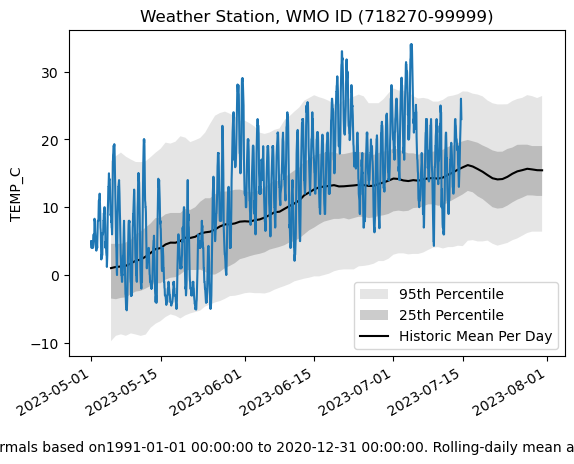

In [7]:
st = plot_st_history(st_id_map = st_id_map, st_dict = st_dict, stations = stations, lat_lon = [50.52, -72.768], plot_var = 'TEMP_C')